In [1]:
import argparse
import os
import sys

from astropy.io import fits

import pint.models as models
import pint.fermi_toas as fermi
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

import scipy.optimize as op
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt

import pint.fitter as fitter
import pint.toa as toa
# import presto.psr_utils as pu
import pint.derived_quantities as pd
import pint.residuals as pr
import pint.simulation as ps
from pint.utils import FTest
from pint.plot_utils import phaseogram
from pint.eventstats import hmw
from pint.models import parameter as pp

from scipy.linalg import cho_solve,cho_factor,solve_triangular,LinAlgError

import astropy.time
from astropy.time import TimeDelta
from astropy.visualization import quantity_support

import copy
from pint.fitter import MaxiterReached, StepProblem
from pint.utils import FTest

import pint.logging
from loguru import logger as log

pint.logging.setup(level='INFO')

1

In [2]:
def phase_wrap(model,ts):
    res = pr.Residuals(ts,model)
    resids = res.phase_resids
    if np.diff(resids).max() > 0.5:
        log.warning('Phase wrap detected')
        for i in range(np.where(np.diff(resids)==np.diff(resids).max())[0][0]+1,len(ts)):
            ts['delta_pulse_number'][i] += -1.0
        res = pr.Residuals(ts,model)
    return res, ts

def powlaw(x, a, b) :
    return a * np.power(x, b)

def get_amp_ind(residuals,nwaves,res_type=None,show_plot=False):
    if res_type == 'time':
        residuals = residuals.time_resids.to_value(u.s) # Are units supposed to be in seconds or days
        title=f'FFT of Time Residuals'                  # Days gets me in the estimated values 
    if res_type == 'phase':
        residuals = residuals.phase_resids
        title=f'FFT of Phase Residuals'
    a = np.fft.fft(np.asarray(residuals.astype(np.float64)))
    psd = np.abs(a)**2
    freqs = np.fft.fftfreq(len(psd),d=100/len(psd))
    lim = int(len(psd)/2)
    xdata = freqs[1:nwaves+1]
    ydata = psd[1:nwaves+1]

    popt,pcov = op.curve_fit(powlaw,xdata,ydata)
    log.info(f'The Amp is {popt[0]} and the spectral index is {popt[1]}')
    log.info(f'The reporting convection is :logA is {np.log10(popt[0])} and the spectral index is {-popt[1]}')
    if show_plot:

        plt.figure(figsize=(15,10))
        plt.plot(freqs[1:lim], popt[0]*np.power(freqs[1:lim],popt[1]),'--',label='Power-law Fit')
        plt.plot(freqs[1:lim],psd[1:lim],'x')
        plt.title(f'{title}', fontsize = 24)
        plt.xscale('log')
        plt.yscale('log')
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Power Spectral Density',fontsize = 16)
        plt.xlabel('Sample Frequency',fontsize = 16)
        plt.grid('True')
    
    return [np.log10(popt[0]),popt[1]]


# Note: This designmatrix function and the only in TNMatrix are transpose of each other
def designmatrix(mjds,nwaves,setpoint,F0,extended=0):
    ndata = len(mjds)
    Tobs = (mjds[-1]-mjds[0]+extended)/365.25
    tnscale = (2/Tobs)**0.5 * F0
    freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
    F = np.empty([ndata,2*nwaves],dtype=np.float64)
    phase= np.empty_like(mjds)
    times = (mjds - setpoint)/365.25 
    #times = (mjds + extended - setpoint)/365.25 ? do I need to extend dt as well?
    for iharm, freq in enumerate(freqs):
        phase[:] = (2*np.pi*freq)*times
        np.cos(phase,out=F[:,2*iharm])
        np.sin(phase,out=F[:,2*iharm+1])
    F *= tnscale
    return freqs, F, Tobs, times, tnscale


def lst_squares_fit(model,ts,residuals,nwaves,extended=0):
    mjds = ts.get_mjds().value
    phase_res = residuals.phase_resids.astype(np.float64)
    
    freqs, F, Tobs, times, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
    
    coeffs, fit_res, _, _ = np.linalg.lstsq(F,phase_res,rcond=None)
    cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    
    log.info(f'The residual of the lstsq fit between the Fourier matrix and the simulated rednoise is: {fit_res}')
    
    return coeffs, cos_coeffs, sin_coeffs

In [3]:
class TNMatrix(object):
    """ Encapsulate the spectral decomposition form of a TN process."""
    def __init__(self,p,freqs,model,ts,zeropad=None):
        """ NB freqs should be in cycles/year!."""
        self.freqs = freqs
        n = zeropad + 2*len(freqs)
        self._H = np.zeros((n,n),dtype=float)
        x,y = np.diag_indices_from(self._H)
        self._x = x[zeropad:]
        self._y = y[zeropad:]
        self.update_p(p)

        self.model = model
#         self.epoch = model.WAVEEPOCH.value if model.WAVEEPOCH else model.PEPOCH.value
        self.epoch = model.PEPOCH.value
        self.mjds = ts.get_mjds().value
        self.scale = (2/(self.mjds[-1]-self.mjds[0])/365.25)**0.5*self.model.F0.value # Units of Hz

    def designmatrix(self):
        ndata = len(self.mjds)
        nharm = len(self.freqs)
        F = np.empty([2*nharm,ndata],dtype=np.float128)
        phase = np.empty_like(self.mjds)
        times = (self.mjds-self.epoch)/365.25 # This is in years now
        for iharm,freq in enumerate(self.freqs):
            phase[:] = (2*np.pi*freq)*times # Units should be freq (1/years) * times (years) to give units of phase
            np.cos(phase,out=F[2*iharm,:])
            np.sin(phase,out=F[2*iharm+1,:])
        F *= self.scale # Units for F should now be in Hz
        return F
    
    def eval_pl(self,p,freqs):
        # Make sure that frequencies are in 1/year
        amp,alpha = p
#         amp = amp**2
        return (10**amp)*freqs**-alpha
    
    def get_values(self):
        return self.coeffs
    
    def H(self):
        """ Return inverse covariance matrix."""
        return self._H
    
    def update_p(self,p):
        freqs = self.freqs * 365.25 # *24*3600 # Frequencies are converted into 1/d
        tn_vals = 2./self.eval_pl(p,freqs) 
        self._H[self._x[::2],self._y[::2]] = tn_vals
        self._H[self._x[1::2],self._y[1::2]] = tn_vals
        self._p = p

In [4]:
# def designmatrix(mjds,nwaves,setpoint,F0,extended=0):
#     ndata = len(mjds)
#     Tobs = (mjds[-1]-mjds[0]+extended)/365.25
#     tnscale = (2/Tobs)**0.5 * F0
#     freqs = np.linspace(1/Tobs,nwaves/Tobs,nwaves)
#     F = np.empty([ndata,2*nwaves],dtype=np.float64)
#     phase= np.empty_like(mjds)
#     times = (mjds - setpoint)/365.25 
#     #times = (mjds + extended - setpoint)/365.25 ? do I need to extend dt as well?
#     for iharm, freq in enumerate(freqs):
#         phase[:] = (2*np.pi*freq)*times
#         np.cos(phase,out=F[:,2*iharm])
#         np.sin(phase,out=F[:,2*iharm+1])
#     F *= tnscale
#     return freqs, F, Tobs, times, tnscale

def joint_designmatrix(model,ts,H_tn=None):
#     mjds = ts.get_mjds().value

    D, params, units = model.designmatrix(ts)
    D *= -model.F0.value
    D = D.transpose()

    if H_tn:
        F = H_tn.designmatrix()
        freqs = H_tn.freqs
        output = np.empty((D.shape[0]+F.shape[0],D.shape[1]),dtype=np.float64)
        output[:D.shape[0]]=D
        output[D.shape[0]:]=F
        return output, F.T, freqs
    
    return D, None, None

def update_model(model,coeffs):
    for i,k in enumerate(model.free_params):
        getattr(model,k).value += coeffs[i+1]
    return model
    

def fit_tn_tm_model(model,ts,p,nwaves,niter=2,offset=0.0,eff_wn=0.01,target_phase=0.5,extended=0,coeffs=None,H_tn=None):
    '''
    Do stuff
    '''
    mjds = ts.get_mjds().value # Should be in value of days
    
    import copy
    model2 = copy.deepcopy(model)
        
    red_coeffs = np.zeros(2*nwaves,dtype=np.float64) if coeffs is None else coeffs
    
    residuals_post = []
    for i in range(niter):        
        fitvals = np.append(offset,[getattr(model,p).value for p in model.free_params])
        print(f'Here are the fitvals on iter {i}: {fitvals}')
        
        # Create timing noise power_law matrix and fourier designmatrix
        n_params = len(fitvals)
        M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
        
        # Calculating the residuals
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        get_values = np.append(fitvals,red_coeffs)
        
        # Linear Algebra time
        if eff_wn is not None:
            Hw = np.diag(np.ones(len(resid))/eff_wn**2)
            T = Hw@M.T
            H = M@T
            X = resid@T
        else:
            H = M@M.T
            X = resid@M.T
        if H_tn is not None:
            H += H_tn.H()
            X -= np.inner(H_tn.H(),get_values)
        
        scale = np.diag(H)**-0.5
        Hscale = H*np.outer(scale,scale)
        Xscale = X*scale
        
        try:
            c = cho_factor(Hscale,lower=True)
        except LinAlgError:
            print('Inverting initial hessian failed')
            Hscale += np.diag(np.diag(Hscale)*1e-3)
            c = cho_factor(Hscale,lower=True)
            
        coeffs = cho_solve(c,Xscale)*scale
        print(f'Here are the postfit shifts for iter {i}: {coeffs}')
        # Calculate new residuals to check for improvement
        model = update_model(model,coeffs)
        red_coeffs = coeffs[n_params:]
#         freqs, F_matrix, Tobs, dt, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
        M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        offset -= np.median(resid)
        residuals_post.append(resid)
        
    M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
    tm_phase = model.phase(ts)
    tm_phase = (tm_phase[0]+tm_phase[1]).value
    tn_phase = np.inner(F_matrix,red_coeffs)
    resid = target_phase-(tn_phase+tm_phase)
    
    if np.max(np.abs(resid)) > 0.05:
        print(f'The deviation (max = {np.max(np.abs(resid)):.2f}, std = {np.std(np.abs(resid)):.2f}) in phase between the original model and the resulting fit is too large to return a good fit model')
        
    return coeffs, resid, freqs, residuals_post

def coeffs_to_wave_coeffs(coeffs):
    cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    return cos_coeffs, sin_coeffs

# def plot_waves(mjds,coeffs,dt,freqs,Tobs,plot=True,single_waves=False):
#     cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
#     fmat_wave = np.zeros(len(dt))
#     if plot:
#         plt.figure(figsize=(10,5))
#         plt.yticks(fontsize=16)
#         plt.xticks(fontsize=16)
#         plt.ylabel('Phase',fontsize = 16)
#         plt.xlabel('MJD (d)',fontsize = 16)
#         plt.grid('True')
#         for i in range(len(cos_coeffs)):
#             wave = cos_coeffs[i]*np.cos(2*np.pi*freqs[i]*dt)+sin_coeffs[i]*np.sin(2*np.pi*freqs[i]*dt)
#             fmat_wave += wave
#             if single_waves:
#                 plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
#                 plt.plot(mjds,wave, label=f'Wave {i}')
#         if not single_waves:
#             plt.title('Summed Wave using Fourier Matrix coefficients', fontsize = 24)
#             plt.plot(mjds,fmat_wave,'+',label='Fourier Matrix Summed Wave')
#     return fmat_wave

def plot_waves(mjds,coeffs,model,nmodes,plot=True,single_waves=False):
    dt = (mjds.value - model.PEPOCH.value)/365.25
    Tobs = (mjds[-1].value-mjds[0].value)/365.25
    freqs = np.linspace(1/Tobs,nmodes/Tobs,nmodes) 
    cos_coeffs, sin_coeffs = np.asarray(coeffs[::2]), np.asarray(coeffs[1::2])
    fmat_wave = np.zeros(len(dt))
    if plot:
        plt.figure(figsize=(10,5))
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Phase',fontsize = 16)
        plt.xlabel('MJD (d)',fontsize = 16)
        plt.grid('True')
        for i in range(len(cos_coeffs)):
            wave = cos_coeffs[i]*np.cos(2*np.pi*freqs[i]*dt)+sin_coeffs[i]*np.sin(2*np.pi*freqs[i]*dt)
            fmat_wave += wave
            if single_waves:
                plt.title('Waves using Fourier Matrix coefficients', fontsize = 24)
                plt.plot(mjds,wave, label=f'Wave {i}')
        if not single_waves:
            plt.title('Summed Wave using Fourier Matrix coefficients', fontsize = 24)
            plt.plot(mjds,fmat_wave,'+',label='Fourier Matrix Summed Wave')
    return fmat_wave

In [9]:
nmodes = 10
extended=0
# model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_wrn.tim')
model, ts = models.get_model_and_toas('J2028_wrn.par','J2028_28TOAs.tim')
# model, ts = models.get_model_and_toas('Geminga_wrn.par','Geminga_wrn.tim')
ts.compute_pulse_numbers(model)
init_residuals,ts = phase_wrap(model,ts)

mjds = ts.get_mjds()
F0_offset = (init_residuals.phase_resids[-1]-init_residuals.phase_resids[0])/(mjds[-1]-mjds[0]).to(u.s)
model.F0.value = model.F0.value - F0_offset.value
corrected_residuals = pr.Residuals(ts,model)

In [10]:
init_fcoeffs, init_ccoeffs, init_scoeffs = lst_squares_fit(model,ts,corrected_residuals,nmodes,extended)
init_fcoeffs = init_fcoeffs*2 # To scale the coefficients correctly
print(init_fcoeffs)

[-0.00115966  0.02774008 -0.00055768 -0.0031707  -0.00020944  0.0011668
  0.00029431  0.00077587 -0.00135831  0.00119906  0.00037639  0.0004391
  0.00040213  0.00023939  0.00131651  0.00082201  0.00024386 -0.00083508
  0.00120393  0.00040816]


In [11]:
# init_fcoeffs=np.random.randn(len(init_fcoeffs))*0.01

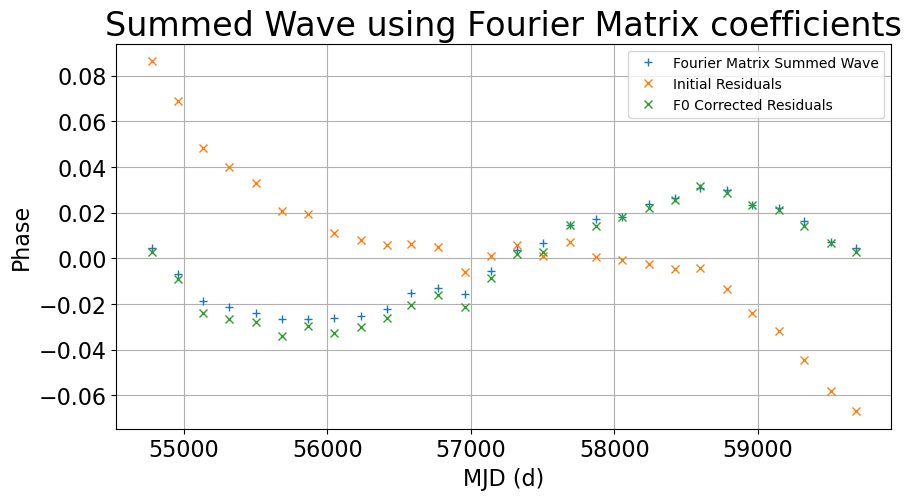

In [12]:
fmat_wave = plot_waves(mjds,init_fcoeffs,model,nmodes)
# fmat_wave = plot_waves(mjds,test_coeffs,dt,freqs,Tobs)
plt.plot(mjds,init_residuals.phase_resids, 'x',label='Initial Residuals')
plt.plot(mjds,corrected_residuals.phase_resids, 'x',label='F0 Corrected Residuals')
# plt.plot(mjds,fmat_wave-init_residuals.phase_resids, 'x',label='Subtracting the Waves')
plt.legend()

INFO     (__main__                      ): The Amp is 0.00011050171110925821 and the spectral index is -0.7411174222614573
INFO     (__main__                      ): The reporting convection is :logA is -3.956630996915023 and the spectral index is 0.7411174222614573


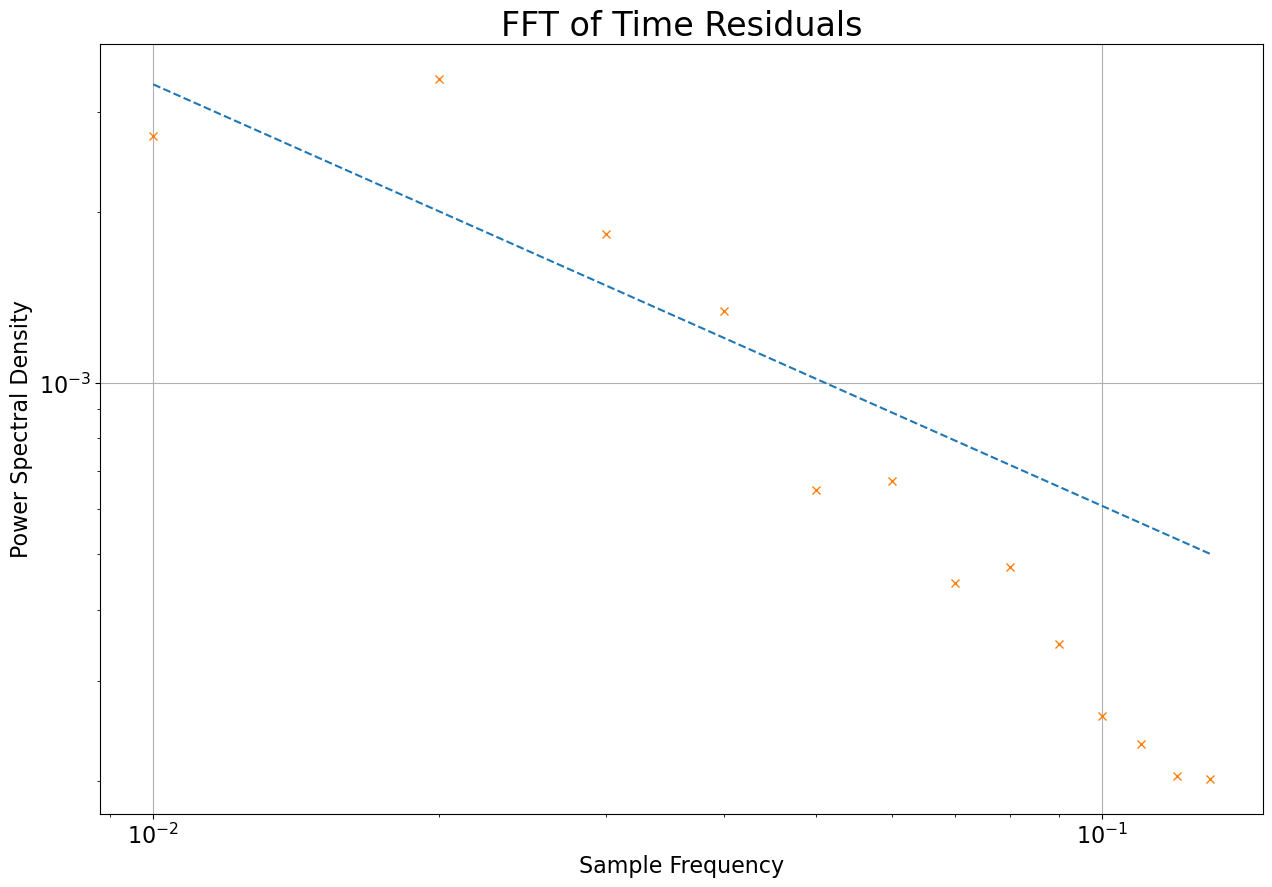

In [90]:
extended=0
Tobs = (mjds[-1] - mjds[0]).to_value(u.yr)
freqs = np.linspace(1/Tobs,nmodes/Tobs,nmodes)
p_p = get_amp_ind(init_residuals,nmodes,res_type='time',show_plot=True) # Initial guess for the logA and gamma

# Freezing all parameters except F0 and F1
for i in model.free_params:
#     if not i.startswith('F'):
    model[i].frozen=True

zeropad = 1 + len(model.free_params) 

H_tn = TNMatrix(p_p,freqs,model,ts,zeropad=zeropad)
M, F, freqs = joint_designmatrix(model,ts,H_tn=H_tn)

In [85]:
freqs

array([0.07441336, 0.14882672, 0.22324008, 0.29765344, 0.3720668 ,
       0.44648016, 0.52089352, 0.59530688, 0.66972024, 0.7441336 ])

In [86]:
print(p_p,np.diag(H_tn.H()))
# fitvals = np.append(-1.0,[getattr(model,p).value for p in model.free_params])
# values = np.append(fitvals, init_fcoeffs)

[-3.956630996915023, -0.7411174222614573] [   0.         1565.74090304 1565.74090304  936.74486854  936.74486854
  693.61267809  693.61267809  560.43177197  560.43177197  475.00813703
  475.00813703  414.97166977  414.97166977  370.17153185  370.17153185
  335.29275855  335.29275855  307.26574638  307.26574638  284.18586626
  284.18586626]


In [91]:
print(p_p,np.diag(H_tn.H()))

[-3.956630996915023, -0.7411174222614573] [0.         0.34370319 0.34370319 0.20562929 0.20562929 0.1522582
 0.1522582  0.12302303 0.12302303 0.10427128 0.10427128 0.09109239
 0.09109239 0.0812581  0.0812581  0.0736017  0.0736017  0.06744936
 0.06744936 0.06238298 0.06238298]


In [11]:
# tm_phase = model.phase(ts)
# tm_phase = (tm_phase[0]+tm_phase[1]).value
# tn_phase = np.inner(F,init_fcoeffs)
# ts.compute_pulse_numbers(model)
# target_phase=ts.get_pulse_numbers()
# resid = target_phase-(tn_phase+tm_phase)

# H = M@M.T
# X = resid@M.T

In [12]:
# X

In [13]:
# H += H_tn.H()
# X -= np.inner(H_tn.H(),values)

In [14]:
# X

In [15]:
# scale = np.diag(H)**-0.5
# scale

In [16]:
# Hscale = H*np.outer(scale,scale)
# Xscale = X*scale
# # print(Hscale)
# print(Xscale)

In [17]:
# c = cho_factor(Hscale,lower=True)
# cho_solve(c,Xscale)

In [18]:
# coeffs = cho_solve(c,Xscale)*scale

In [43]:
ts.compute_pulse_numbers(model)
target_phase=ts.get_pulse_numbers()
coeffs,post_residuals,freqs, fit_resids = fit_tn_tm_model(model,ts,p_p,nmodes,eff_wn=None,offset=-1.0,target_phase=target_phase,extended=extended,coeffs=init_fcoeffs,H_tn=H_tn)

Here are the fitvals on iter 0: [-1.]
Here are the postfit shifts for iter 0: [ 0.17624639  0.00115977 -0.02774162  0.00055767  0.00317099  0.00020952
 -0.00116694 -0.00029444 -0.00077597  0.00135866 -0.00119927 -0.00037656
 -0.00043917 -0.00040203 -0.00023942 -0.00131709 -0.00082223 -0.0002438
  0.00083521 -0.00120447 -0.00040837]
Here are the fitvals on iter 1: [-0.81881027]
Here are the postfit shifts for iter 1: [ 0.17624639 -0.00115967  0.02774006 -0.00055767 -0.00317069 -0.00020944
  0.00116679  0.00029432  0.00077587 -0.00135832  0.00119906  0.00037639
  0.00043911  0.00040212  0.00023938  0.00131651  0.00082202  0.00024385
 -0.00083508  0.00120394  0.00040816]
The deviation (max = 0.21, std = 0.02) in phase between the original model and the resulting fit is too large to return a good fit model


In [20]:
fitvals = np.append(-1.0,[getattr(model,p).value for p in model.free_params])
fitvals

array([-1.])

In [44]:
coeffs[1:]-init_fcoeffs

<Quantity [-5.70290343e-17, -8.98586761e-16,  1.09092423e-15,
           -2.16840434e-16,  4.90005172e-16,  1.14730274e-15,
           -1.35492745e-15,  6.09104781e-16, -1.15901212e-15,
           -1.37823780e-15, -1.91074370e-15, -1.52937558e-15,
            7.79649782e-16, -3.97620305e-15,  1.56797318e-15,
            4.37258736e-16,  2.35036057e-15, -1.33877284e-15,
            1.13646072e-15,  5.88401940e-15]>

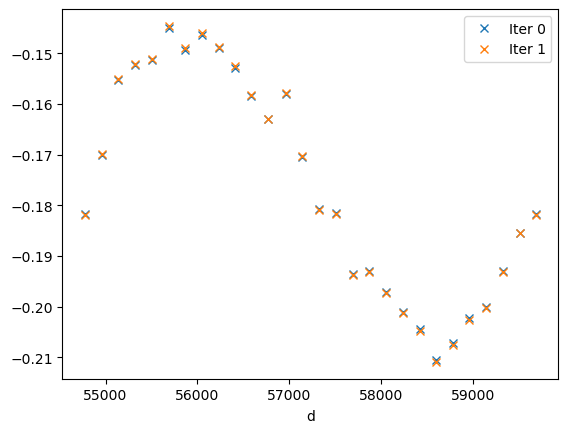

In [45]:
for i in range(len(fit_resids)):
    plt.plot(mjds,fit_resids[i],'x',label=f'Iter {i}')
# plt.plot(post_residuals,'x',label='Post')
# plt.plot(init_residuals.phase_resids,'+',label='Initial')
plt.legend()

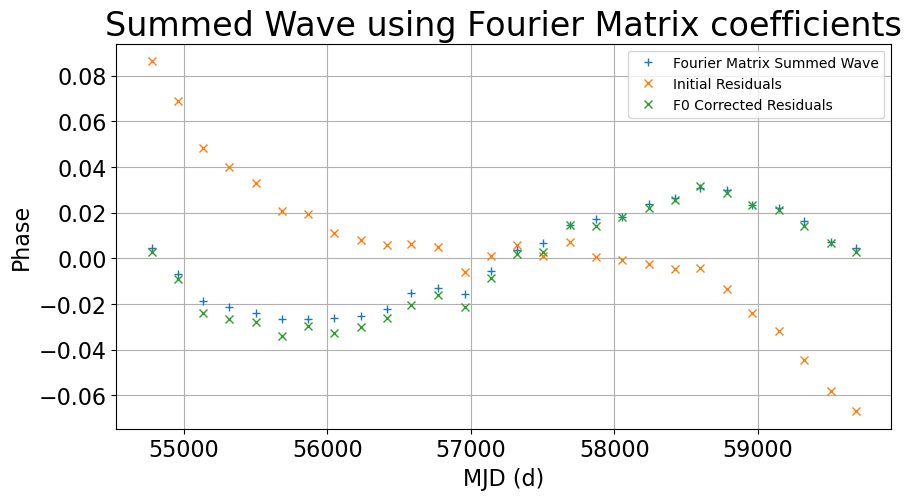

In [46]:
fmat_wave2 = plot_waves(mjds,coeffs[zeropad:],model,nmodes)
# plt.plot(mjds,fmat_wave2-fmat_wave,'*',label='Postfit-Prefit')
plt.plot(mjds,init_residuals.phase_resids, 'x',label='Initial Residuals')
plt.plot(mjds,corrected_residuals.phase_resids, 'x',label='F0 Corrected Residuals')
# plt.plot(mjds,fmat_wave-init_residuals.phase_resids, 'x',label='Subtracting the Waves')
plt.legend()

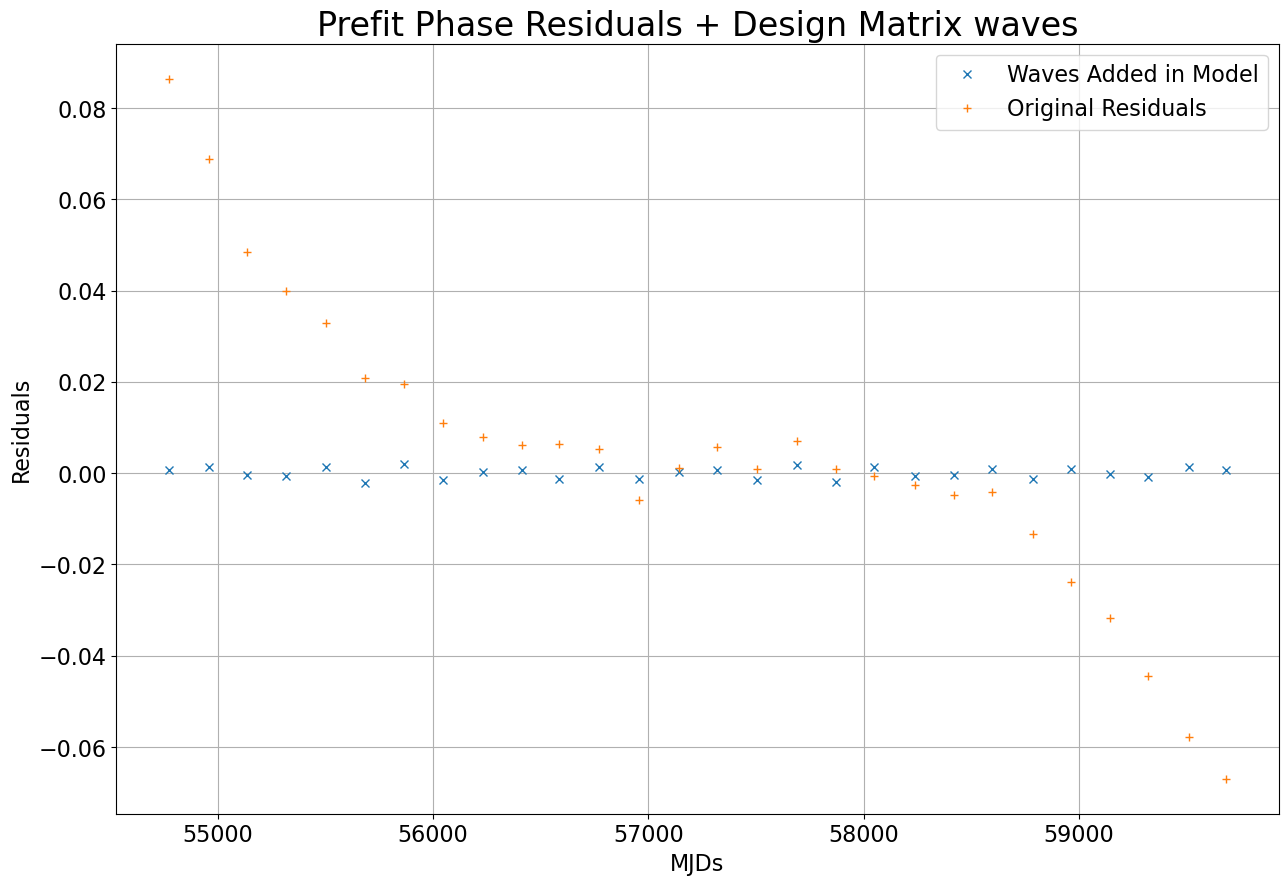

In [47]:
model = models.get_model('J2028_wrn.par')
# model = models.get_model('Geminga_wrn.par')

model.F0.value = model.F0.value - F0_offset.value
# I scaled the initial coefficients by a factor of 2, that I have to remove from the current coefficients
cos_Xcoeffs, sin_Xcoeffs = coeffs_to_wave_coeffs(coeffs[zeropad:]/2)
tnscale = (2/Tobs)**0.5 * model.F0.value
cos_Xcoeffs = -cos_Xcoeffs*tnscale/model.F0.value
sin_Xcoeffs = -sin_Xcoeffs*tnscale/model.F0.value

wave_model = models.wave.Wave()
wave_model.remove_param('WAVE1')
wave_model.WAVE_OM.quantity = 2*np.pi/(ts.last_MJD-ts.first_MJD+extended*u.d)
wave_model.WAVE_OM.uncertainty = 0.0
wave_model.WAVEEPOCH.quantity = model.PEPOCH.quantity
for i in range(nmodes):
    wave_model.add_param(pp.prefixParameter(name=f'WAVE{i+1}',value=[sin_Xcoeffs[i],cos_Xcoeffs[i]],type_match='pair',parameter_type='pair',long_double=True,units=u.s))

model.add_component(wave_model)

# model.F0.value = model.F0.value - F0_offset.value
ts.compute_pulse_numbers(model)
res,ts = phase_wrap(model,ts)
# res = pr.Residuals(ts,model)
plt.figure(figsize=(15,10))
plt.plot(mjds,res.phase_resids,'x',label='Waves Added in Model')
plt.plot(mjds,init_residuals.phase_resids,'+',label='Original Residuals')
plt.title('Prefit Phase Residuals + Design Matrix waves', fontsize = 24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Residuals',fontsize = 16)
plt.xlabel('MJDs',fontsize = 16)
plt.grid('True')
plt.legend(fontsize=16)
plt.show()

INFO     (pint.fitter                   ): For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


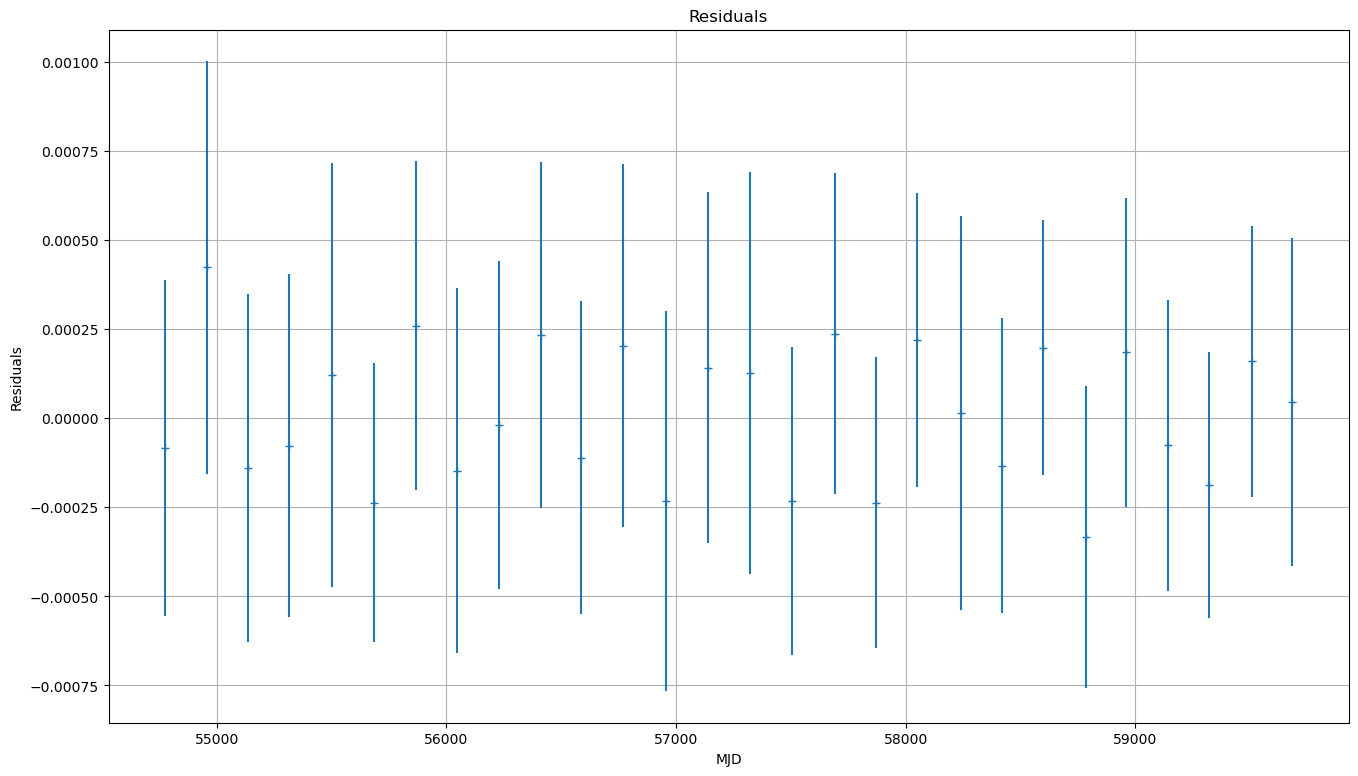

In [25]:
f = fitter.Fitter.auto(ts,model)
f.fit_toas()
f.plot()